In [21]:
import importlib
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import nue as nue
importlib.reload(nue)

<module 'nue' from '/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/nue.py'>

In [3]:
nue_file = "/sbnd/data/users/lynnt/v09_75_03_02/rockbox/intrnue_rockbox.df"
nue_hdr_df_0 = pd.read_hdf(nue_file,key="hdr")
nue_nuu_df_0 = pd.read_hdf(nue_file,key="mcnu")
nue_nuprim_df_0 = pd.read_hdf(nue_file,key="mcnuprim")
nue_slctrk_df_0 = pd.read_hdf(nue_file,key="slctrk")
nue_slcshw_df_0 = pd.read_hdf(nue_file,key="slcshw")

nu_idx_set = ["ntuple","entry","nu_index"]
slc_idx_set = ["ntuple","entry","rec.slc__index"]

nue_hdr_df = nue.flatten_df(nue_hdr_df_0)[["ntuple","entry","rec_hdr_run","rec_hdr_subrun","rec_hdr_evt","rec_hdr_pot"]].rename(columns={"rec_hdr_subrun":"subrun","rec_hdr_run":"run","rec_hdr_evt":"event"})
nue_sub_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/rockbox/ana_opt0_intrnue_rockbox.root:opt0finder/flash_match_tree").arrays(['run','subrun','event'],library="pd").drop_duplicates()
nue_sub_df = nue_hdr_df.merge(nue_sub_opt0_df,on=["run","subrun",'event'],how="inner")

In [4]:
bnb_file = "/sbnd/data/users/lynnt/v09_75_03_02/rockbox/bnb_rockbox.df"
bnb_hdr_df_0 = pd.read_hdf(bnb_file,key="hdr")
bnb_nuu_df_0 = pd.read_hdf(bnb_file,key="mcnu")
bnb_nuprim_df_0 = pd.read_hdf(bnb_file,key="mcnuprim")
bnb_slctrk_df_0 = pd.read_hdf(bnb_file,key="slctrk")
bnb_slcshw_df_0 = pd.read_hdf(bnb_file,key="slcshw")

bnb_hdr_df = nue.flatten_df(bnb_hdr_df_0)[["ntuple","entry","rec_hdr_run","rec_hdr_subrun","rec_hdr_evt","rec_hdr_pot"]].rename(columns={"rec_hdr_subrun":"subrun","rec_hdr_run":"run","rec_hdr_evt":"event"})
bnb_sub_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/rockbox/ana_opt0_bnb_rockbox.root:opt0finder/flash_match_tree").arrays(['run','subrun','event'],library="pd").drop_duplicates()
bnb_sub_df = bnb_hdr_df.merge(bnb_sub_opt0_df,on=["run","subrun",'event'],how="inner")

In [25]:
print("bnb POT:", np.sum(bnb_sub_df.rec_hdr_pot))
print("nue POT:", np.sum(nue_sub_df.rec_hdr_pot))
nue.nue_scale = np.sum(bnb_sub_df.rec_hdr_pot) / np.sum(nue_sub_df.rec_hdr_pot)
print("scale nue events down by: ", nue.nue_scale)

bnb POT: 1.4196215e+18
nue POT: 8.083963e+19
scale nue events down by:  0.01756096


In [6]:
# make nue dataframes
nue_nuprim_df = nue_nuprim_df_0.copy()

whereFV = nue.maskTrueVtxFv(nue_nuprim_df)
whereSig = ((nue_nuprim_df.iscc==1) & (abs(nue_nuprim_df.pdg)==12) & (abs(nue_nuprim_df.prim.pdg)==11))# & (nue_nuprim_df.prim.startE > 0.2) )
nue_nuprim_df = nue.defineBackground(nue_nuprim_df)
nue_nuprim_df["signal"] = np.where(whereFV & whereSig,0,nue_nuprim_df["signal"])

nue_nu_df = nue_nuprim_df.loc[:,:,:,0]
nue_nu_df = nue.flatten_df(nue_nu_df)
nue_nu_df["nu_index"] = nue_nu_df["rec.mc.nu__index"]

# get the dataframe that contains the counts of each PDG per event 
nue_pdg_counts = nue.getPDGCounts(nue_nuprim_df)

# merge the pdg counts into the full nue_nu_df 
nue_nu_df = nue_nu_df.merge(nue_pdg_counts,how="left",on=["ntuple","entry","rec.mc.nu__index"])

# get slcpfp dataframe 
slcpfp_nue_df = nue.getPFP(nue_slcshw_df_0,nue_slctrk_df_0)

# merge slcpfp with neutrino events 
slcpfp_nue_nu_df = slcpfp_nue_df.merge(nue_nu_df,on=nu_idx_set,how="left")
slcpfp_nue_nu_df["signal"] = np.where(slcpfp_nue_df.slc_tmatch_idx==-999,5,slcpfp_nue_nu_df['signal'])

In [7]:
# make bnb dataframes
bnb_nuprim_df = bnb_nuprim_df_0.copy()

whereFV = nue.maskTrueVtxFv(bnb_nuprim_df)
whereSig = ((bnb_nuprim_df.iscc==1) & (abs(bnb_nuprim_df.pdg)==12) & (abs(bnb_nuprim_df.prim.pdg)==11))# & (bnb_nuprim_df.prim.startE > 0.2) )
bnb_nuprim_df = nue.defineBackground(bnb_nuprim_df)
bnb_nuprim_df["signal"] = np.where(whereFV & whereSig,0,bnb_nuprim_df["signal"])

bnb_nu_df = bnb_nuprim_df.loc[:,:,:,0]
bnb_nu_df = nue.flatten_df(bnb_nu_df)
bnb_nu_df["nu_index"] = bnb_nu_df["rec.mc.nu__index"]

# get the dataframe that contains the counts of each PDG per event 
bnb_pdg_counts = nue.getPDGCounts(bnb_nuprim_df)

# merge the pdg counts into the full bnb_nu_df 
bnb_nu_df = bnb_nu_df.merge(bnb_pdg_counts,how="left",on=["ntuple","entry","rec.mc.nu__index"])

# remove nue events from the bnb sample
bnb_rm_nue = nue.flatten_df(bnb_nuu_df_0[abs(bnb_nuu_df_0.pdg) == 12])[["entry"]]
bnb_nu_df = (bnb_nu_df.merge(bnb_rm_nue,how="left",on=["entry"], indicator=True)
     .query('_merge == "left_only"')
     .drop('_merge', 1))

# get slcpfp dataframe 
slcpfp_bnb_df = nue.getPFP(bnb_slcshw_df_0,bnb_slctrk_df_0)

# merge slcpfp with neutrino events 
slcpfp_bnb_nu_df = slcpfp_bnb_df.merge(bnb_nu_df,on=nu_idx_set,how="left")
slcpfp_bnb_nu_df["signal"] = np.where(slcpfp_bnb_df.slc_tmatch_idx==-999,5,slcpfp_bnb_nu_df['signal'])

In [8]:
nue_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/rockbox/ana_opt0_intrnue_rockbox.root:opt0finder/flash_match_tree").arrays(['run','subrun','event','tpc','pfpid','score','hypo_pe','flash_pe'],library="pd")
nue_opt0_df["frac_pe"] = (nue_opt0_df.hypo_pe - nue_opt0_df.flash_pe)/nue_opt0_df.flash_pe
nue_opt0_df = nue_opt0_df[nue_opt0_df.pfpid != -1]

# for multiple matches per slice, take the match with the best score
nue_opt0_df = nue_opt0_df[(nue_opt0_df.score == nue_opt0_df.groupby(["run","subrun","event","pfpid"])["score"].transform(max))]
nue_hdr_opt0_df = nue_sub_df[["ntuple","entry","run","subrun","event"]].drop_duplicates().merge(nue_opt0_df,how="left",on=["run","subrun","event"])
slcpfp_nue_nu_df = slcpfp_nue_nu_df.merge(nue_hdr_opt0_df.rename(columns={"pfpid":"slc_self"}),on=["ntuple","entry","slc_self"],how="left")

In [9]:
bnb_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/rockbox/ana_opt0_bnb_rockbox.root:opt0finder/flash_match_tree").arrays(['run','subrun','event','tpc','pfpid','score','hypo_pe','flash_pe'],library="pd")
bnb_opt0_df["frac_pe"] = (bnb_opt0_df.hypo_pe - bnb_opt0_df.flash_pe)/bnb_opt0_df.flash_pe
bnb_opt0_df = bnb_opt0_df[bnb_opt0_df.pfpid != -1]

# for multiple matches per slice, take the match with the best score
bnb_opt0_df = bnb_opt0_df[(bnb_opt0_df.score == bnb_opt0_df.groupby(["run","subrun","event","pfpid"])["score"].transform(max))]
bnb_hdr_opt0_df = bnb_sub_df[["ntuple","entry","run","subrun","event"]].drop_duplicates().merge(bnb_opt0_df,how="left",on=["run","subrun","event"])
slcpfp_bnb_nu_df = slcpfp_bnb_nu_df.merge(bnb_hdr_opt0_df.rename(columns={"pfpid":"slc_self"}),on=["ntuple","entry","slc_self"],how="left")

In [17]:
# print number of slc/evt for nue selection
print("number of signal events:", len(nue.get_signal_evt(nue_nu_df)))
print("number of signal slices (evt) after reconstruction: ", 
      len(nue.get_signal_slc(slcpfp_nue_nu_df)),
      "(",len(nue.get_signal_evt(slcpfp_nue_nu_df)),")")

# pre-selection
## reco vertex in FV 
## not a clear cosmic 
## at least one pfp in a slice with track score < 0.6
pre_slcpfp_nue_nu_df = nue.cutPreselection(slcpfp_nue_nu_df)
print("number of signal slices (evt) after pre-selection: ", 
      len(nue.get_signal_slc(pre_slcpfp_nue_nu_df)),
      "(",len(nue.get_signal_evt(pre_slcpfp_nue_nu_df)),")")
# containment
con_slcpfp_nue_nu_df = nue.cutContainment(pre_slcpfp_nue_nu_df)
print("number of signal slices (evt) after containment: ", 
      len(nue.get_signal_slc(con_slcpfp_nue_nu_df)),
      "(",len(nue.get_signal_evt(con_slcpfp_nue_nu_df)),")")
# loose cosmic rejection 
lcr_slcpfp_nue_nu_df = nue.cutCRUMBS(con_slcpfp_nue_nu_df)
print("number of signal slices (evt) after loose cosmic rejection: ",
        len(nue.get_signal_slc(lcr_slcpfp_nue_nu_df)),
        "(",len(nue.get_signal_evt(lcr_slcpfp_nue_nu_df)),")")
# muon rejection
mask_muon_dazzle = ~(lcr_slcpfp_nue_nu_df.groupby(slc_idx_set)["pfp_trk_dazzle_muonScore"].transform(lambda x: (x > 0.2).any()))
mrj_slcpfp_nue_nu_df = lcr_slcpfp_nue_nu_df[mask_muon_dazzle]
print("number of signal slices (evt) after muon rejection: ",
        len(nue.get_signal_slc(mrj_slcpfp_nue_nu_df)),
        "(", len(nue.get_signal_evt(mrj_slcpfp_nue_nu_df)),")")

mask_electron_razzle = (mrj_slcpfp_nue_nu_df.groupby(slc_idx_set)["pfp_shw_razzle_electronScore"].transform(lambda x: (x > 0.5).any()))
esl_slcpfp_nue_nu_df = mrj_slcpfp_nue_nu_df[mask_electron_razzle]
print("number of signal slices (evt) after electron selection: ",
      len(nue.get_signal_slc(esl_slcpfp_nue_nu_df)),
      "(",len(nue.get_signal_evt(esl_slcpfp_nue_nu_df)),")")

# mask_shower_energy = (esl_slcpfp_nue_nu_df.groupby(slc_idx_set)["shw_energy"].transform(lambda x: (x > 0.2).any()))
# shw_slcpfp_nue_nu_df = esl_slcpfp_nue_nu_df[mask_shower_energy]
# print("number of signal slices after shower energy cut: ",len(nue.get_signal_slc(shw_slcpfp_nue_nu_df)))

number of signal events: 2675
number of signal slices (evt) after reconstruction:  2912 ( 2636 )
number of signal slices (evt) after pre-selection:  2696 ( 2551 )
number of signal slices (evt) after containment:  2273 ( 2147 )
number of signal slices (evt) after loose cosmic rejection:  2151 ( 2110 )
number of signal slices (evt) after muon rejection:  1903 ( 1869 )
number of signal slices (evt) after electron selection:  1333 ( 1331 )


In [11]:
# print number of slc/evnt for bnb
print("number of backgr slices after reconstruction: ", len(nue.get_backgr_slc(slcpfp_bnb_nu_df)))
# pre-selection
## reco vertex in FV 
## not a clear cosmic 
## at least one pfp in a slice with track score < 0.6
pre_slcpfp_bnb_nu_df = nue.cutPreselection(slcpfp_bnb_nu_df)
print("number of backgr slices after pre-selection: ", len(nue.get_backgr_slc(pre_slcpfp_bnb_nu_df)))
# containment
con_slcpfp_bnb_nu_df = nue.cutContainment(pre_slcpfp_bnb_nu_df)
print("number of backgr slices after containment: ", len(nue.get_backgr_slc(con_slcpfp_bnb_nu_df)))
# loose cosmic rejection
lcr_slcpfp_bnb_nu_df = nue.cutCRUMBS(con_slcpfp_bnb_nu_df)
print("number of backgr slices after loose cosmic rejection: ", len(nue.get_backgr_slc(lcr_slcpfp_bnb_nu_df)))
# muon rejection
mask_muon_dazzle = ~(lcr_slcpfp_bnb_nu_df.groupby(slc_idx_set)["pfp_trk_dazzle_muonScore"].transform(lambda x: (x > 0.2).any()))
mrj_slcpfp_bnb_nu_df = lcr_slcpfp_bnb_nu_df[mask_muon_dazzle]
print("number of backgr slices after muon rejection: ",len(nue.get_backgr_slc(mrj_slcpfp_bnb_nu_df)))
# electron selection
mask_electron_razzle = (mrj_slcpfp_bnb_nu_df.groupby(slc_idx_set)["pfp_shw_razzle_electronScore"].transform(lambda x: (x > 0.5).any()))
esl_slcpfp_bnb_nu_df = mrj_slcpfp_bnb_nu_df[mask_electron_razzle]
print("number of backgr slices after electron selection: ",len(nue.get_backgr_slc(esl_slcpfp_bnb_nu_df)))
# shw energy cut 
mask_shower_energy = (esl_slcpfp_bnb_nu_df.groupby(slc_idx_set)["shw_energy"].transform(lambda x: (x > 0.2).any()))
shw_slcpfp_bnb_nu_df = esl_slcpfp_bnb_nu_df[mask_shower_energy]
print("number of backgr slices after shower energy cut: ",len(nue.get_backgr_slc(shw_slcpfp_bnb_nu_df)))

number of backgr slices after reconstruction:  163664
number of backgr slices after pre-selection:  13401
number of backgr slices after containment:  10227
number of backgr slices after loose cosmic rejection:  4367
number of backgr slices after muon rejection:  2054
number of backgr slices after electron selection:  318
number of backgr slices after shower energy cut:  183


## Q->L Study

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # Remove the CWD from sys.path while we load stuff.
/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  app.launch_new_instance()


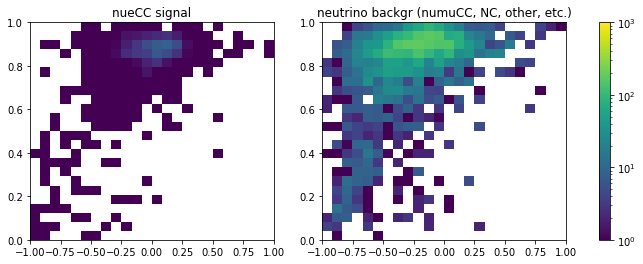

In [12]:
# distribution of fractional difference vs. completeness after pre-selection for signal vs backgr
fig, axes = plt.subplots(1,2,figsize=(12,4))

this_nue = mrj_slcpfp_nue_nu_df.copy()
this_bnb = mrj_slcpfp_bnb_nu_df.copy()
this_nue = this_nue[(this_nue.frac_pe.isna()==False)]
this_bnb = this_bnb[(this_bnb.frac_pe.isna()==False)]
nue_signal_h, xedges, yedges = np.histogram2d(this_nue.query("signal == 0").frac_pe,this_nue.query("signal == 0").slc_tmatch_eff,bins=[np.linspace(-1,1,25),np.linspace(0,1,25)])
nue_signal_h = nue_signal_h*nue.nue_scale
im_signal = axes[0].imshow(nue_signal_h.T,origin="lower",extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]],aspect="auto",norm=mpl.colors.LogNorm(), vmin=1, vmax=1000)

nue_backgr_h, xedges, yedges = np.histogram2d(this_nue.query("signal!=0").frac_pe,this_nue.query("signal!=0").slc_tmatch_eff,bins=[np.linspace(-1,1,25),np.linspace(0,1,25)])
bnb_backgr_h, ______, ______ = np.histogram2d(this_bnb.query("signal!=0").frac_pe,this_bnb.query("signal!=0").slc_tmatch_eff,bins=[np.linspace(-1,1,25),np.linspace(0,1,25)])

this_backgr = nue.nue_scale*nue_backgr_h + bnb_backgr_h
im_bacgkr = axes[1].imshow(this_backgr.T,origin="lower",extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]],aspect="auto",norm=mpl.colors.LogNorm(), vmin=1, vmax=1000)
# set the limits of the colorbar to be the same for both plots
vmin, vmax = im_signal.get_clim()
fig.colorbar(im_bacgkr, ax=axes, ticks=np.logspace(np.log10(vmin), np.log10(vmax), num=4))

axes[0].set_title("nueCC signal")
axes[1].set_title("neutrino backgr (numuCC, NC, other, etc.)")
plt.show()


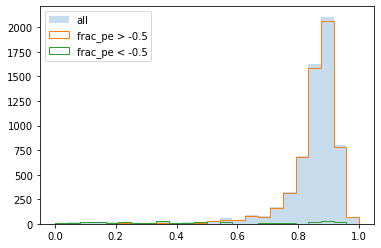

percentage of signal below 50% completeness:  0.0389
percentage of incomplete (<50%) signal that as frac_pe < -0.5: 0.7568


In [13]:
this_df = mrj_slcpfp_nue_nu_df.copy()
this_df = this_df.query("signal==0")
this_df["frac_pe"] = np.where(this_df.frac_pe.isna(),-2,this_df.frac_pe)

plt.hist(this_df.slc_tmatch_eff,                                         bins=np.linspace(0,1,25),alpha = 0.25, label="all")
plt.hist(this_df.query("frac_pe > -0.5").slc_tmatch_eff,                 bins=np.linspace(0,1,25),histtype="step",lw=1,label="frac_pe > -0.5")
plt.hist(this_df.query("frac_pe < -0.5 & frac_pe != -2 ").slc_tmatch_eff,bins=np.linspace(0,1,25),histtype="step",lw=1,label="frac_pe < -0.5")
plt.legend()
plt.show()

print("percentage of signal below 50% completeness: ", np.round(len(nue.get_signal_slc(this_df.query("slc_tmatch_eff < 0.5")))/len(nue.get_signal_slc(this_df)),4))
print("percentage of incomplete (<50%) signal that as frac_pe < -0.5:", np.round(len(nue.get_signal_slc(this_df.query("slc_tmatch_eff < 0.5 & frac_pe < -0.5")))/len(nue.get_signal_slc(this_df.query("slc_tmatch_eff < 0.5"))),4))

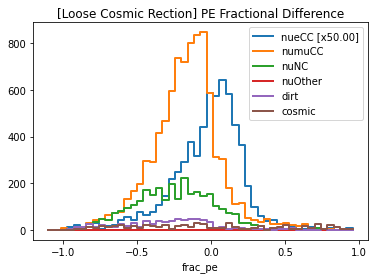

In [32]:
this_bnb = lcr_slcpfp_bnb_nu_df
this_nue = lcr_slcpfp_nue_nu_df

nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="frac_pe",
             bins=np.linspace(-1.1,1,50),
             title="[Loose Cosmic Rection] PE Fractional Difference",
             mult_factor=50
             )

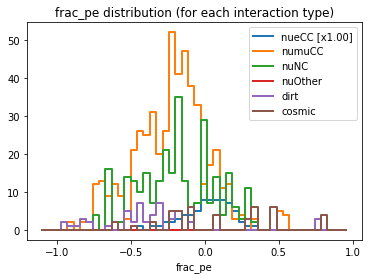

In [144]:
this_bnb = esl_slcpfp_bnb_nu_df
this_nue = esl_slcpfp_nue_nu_df

nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="frac_pe",
             bins=np.linspace(-1.1,1,50),
             mult_factor=1
             )

## More Selection

In [303]:
# purity and efficiency after each step
eff_den = len(nue.get_signal_evt(nue_nu_df)) # total number of signal events
# reconstruction
print("reconstruction")
print("----------------")
pur_num = len(nue.get_signal_slc(slcpfp_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(slcpfp_nue_nu_df))*nue.nue_scale + len(nue.get_slc(slcpfp_bnb_nu_df))

eff_num = len(nue.get_signal_evt(slcpfp_nue_nu_df))

print("purity (slc): ", np.round(100*pur_num/pur_den,2))
print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))
print("\n")

print("preselection")
print("----------------")
pur_num = len(nue.get_signal_slc(pre_slcpfp_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(pre_slcpfp_nue_nu_df))*nue.nue_scale + len(nue.get_slc(pre_slcpfp_bnb_nu_df))

eff_num = len(nue.get_signal_evt(pre_slcpfp_nue_nu_df))

print("purity (slc): ", np.round(100*pur_num/pur_den,2))
print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))
print("\n")

print("containment")
print("----------------")
pur_num = len(nue.get_signal_slc(con_slcpfp_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(con_slcpfp_nue_nu_df))*nue.nue_scale + len(nue.get_slc(con_slcpfp_bnb_nu_df))

eff_num = len(nue.get_signal_evt(con_slcpfp_nue_nu_df))

print("purity (slc): ", np.round(100*pur_num/pur_den,2))
print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))
print("\n")

print("loose cosmic rejection")
print("----------------")
pur_num = len(nue.get_signal_slc(lcr_slcpfp_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(lcr_slcpfp_nue_nu_df))*nue.nue_scale + len(nue.get_slc(lcr_slcpfp_bnb_nu_df))

eff_num = len(nue.get_signal_evt(lcr_slcpfp_nue_nu_df))

print("purity (slc): ", np.round(100*pur_num/pur_den,2))
print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))
print("\n")

print("muon rejection")
print("----------------")
pur_num = len(nue.get_signal_slc(mrj_slcpfp_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(mrj_slcpfp_nue_nu_df))*nue.nue_scale + len(nue.get_slc(mrj_slcpfp_bnb_nu_df))

eff_num = len(nue.get_signal_evt(mrj_slcpfp_nue_nu_df))

print("purity (slc): ", np.round(100*pur_num/pur_den,2))
print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))
print("\n")

print("electron selection")
print("----------------")
pur_num = len(nue.get_signal_slc(esl_slcpfp_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(esl_slcpfp_nue_nu_df))*nue.nue_scale + len(nue.get_slc(esl_slcpfp_bnb_nu_df))

eff_num = len(nue.get_signal_evt(esl_slcpfp_nue_nu_df))

print("purity (slc): ", np.round(100*pur_num/pur_den,2))
print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))
print("\n")

print("shower energy cut")
print("----------------")
pur_num = len(nue.get_signal_slc(shw_slcpfp_nue_nu_df))*nue.nue_scale
pur_den = len(nue.get_slc(shw_slcpfp_nue_nu_df))*nue.nue_scale + len(nue.get_slc(shw_slcpfp_bnb_nu_df))

eff_num = len(nue.get_signal_evt(shw_slcpfp_nue_nu_df))

print("purity (slc): ", np.round(100*pur_num/pur_den,2))
print("efficiency (evt): ", np.round(100*eff_num/eff_den,2))
print("\n")

reconstruction
----------------
purity (slc):  0.03
efficiency (evt):  98.54


preselection
----------------
purity (slc):  0.35
efficiency (evt):  95.36


containment
----------------
purity (slc):  0.39
efficiency (evt):  80.26


loose cosmic rejection
----------------
purity (slc):  0.85
efficiency (evt):  78.88


muon rejection
----------------
purity (slc):  1.59
efficiency (evt):  69.87


electron selection
----------------
purity (slc):  6.83
efficiency (evt):  49.76


shower energy cut
----------------
purity (slc):  11.02
efficiency (evt):  48.37




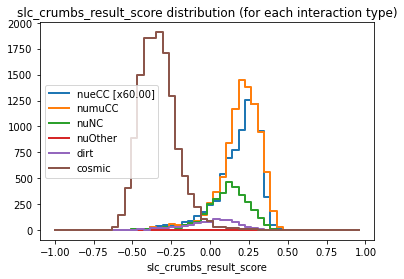

In [304]:
this_bnb = con_slcpfp_bnb_nu_df
this_nue = con_slcpfp_nue_nu_df

nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="slc_crumbs_result_score",
             bins=np.linspace(-1,1.0,50),
             mult_factor=60)

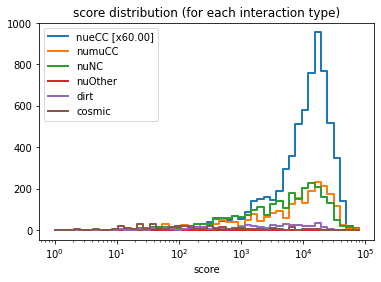

In [336]:
this_bnb = mrj_slcpfp_bnb_nu_df
this_nue = mrj_slcpfp_nue_nu_df

plt.xscale('log')
nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="score",
             bins=np.logspace(0,5,50),
             mult_factor=60)

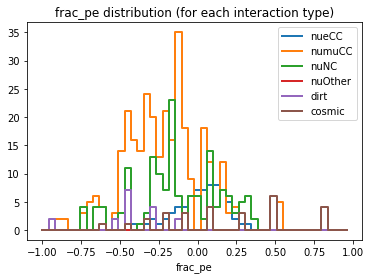

In [340]:
this_bnb = shw_slcpfp_bnb_nu_df
this_nue = shw_slcpfp_nue_nu_df
nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="frac_pe",
             bins=np.linspace(-1,1,50),
             mult_factor=None)

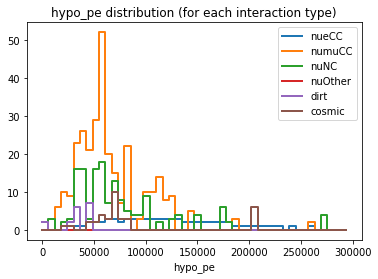

In [334]:
this_bnb = shw_slcpfp_bnb_nu_df
this_nue = shw_slcpfp_nue_nu_df

# change nan values in dataframe to -1
# this_bnb["flash_pe"] = this_bnb["flash_pe"].fillna(-1)
# this_nue["flash_pe"] = this_nue["flash_pe"].fillna(-1)

nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var="hypo_pe",
             bins=np.linspace(-1,3e5,50),)

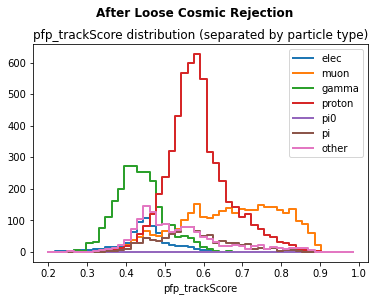

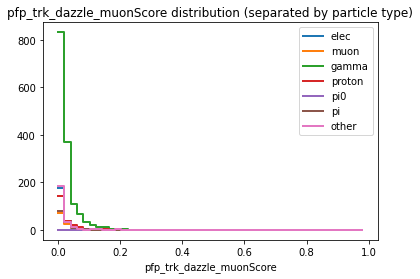

In [306]:
this_bnb = lcr_slcpfp_bnb_nu_df
this_nue = lcr_slcpfp_nue_nu_df

plt.suptitle("After Loose Cosmic Rejection", y=1.01, fontweight='bold')
nue.plot_var_pdg(df=this_bnb,
                 df_add=this_nue,
                 var="pfp_trackScore",
                 bins=np.linspace(0.2,1.0,50),)

this_bnb = lcr_slcpfp_bnb_nu_df[lcr_slcpfp_bnb_nu_df.pfp_trackScore < 0.5]
this_nue = lcr_slcpfp_nue_nu_df[lcr_slcpfp_nue_nu_df.pfp_trackScore < 0.5]
nue.plot_var_pdg(df=this_bnb,
                 df_add=this_nue,
                 var="pfp_trk_dazzle_muonScore",
                 bins=np.linspace(0,1.0,50),)

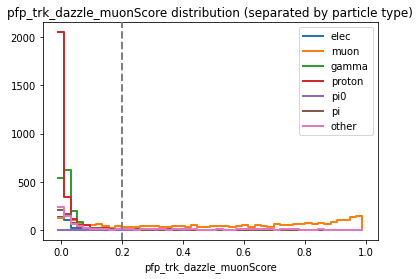

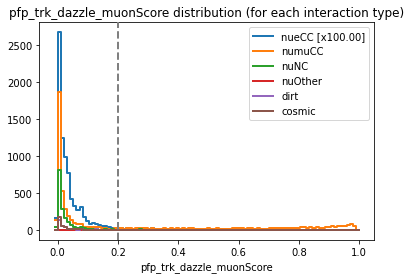

In [307]:
this_bnb = lcr_slcpfp_bnb_nu_df
this_nue = lcr_slcpfp_nue_nu_df

nue.plot_var_pdg(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_trk_dazzle_muonScore",
             bins=np.linspace(-0.01,1.01,50),
             cut_val = [0.2],
             )

nue.plot_var(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_trk_dazzle_muonScore",
             bins=np.linspace(-0.01,1.01,100),
             cut_val = [0.2],
             mult_factor=100)

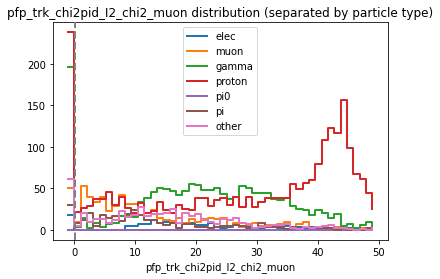

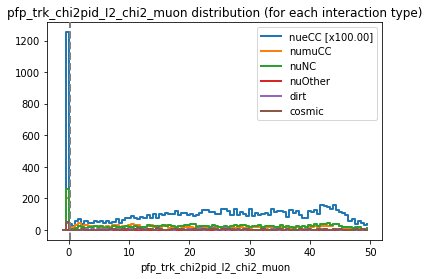

In [308]:
this_bnb = mrj_slcpfp_bnb_nu_df
this_nue = mrj_slcpfp_nue_nu_df

nue.plot_var_pdg(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_trk_chi2pid_I2_chi2_muon",
             bins=np.linspace(-1,50,50),
             cut_val = [0.2],
             )

nue.plot_var(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_trk_chi2pid_I2_chi2_muon",
             bins=np.linspace(-1,50,100),
             cut_val = [0.2],
             mult_factor=100)

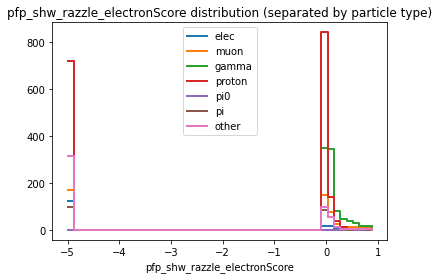

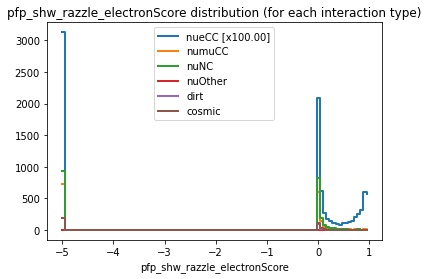

In [309]:
this_bnb = mrj_slcpfp_bnb_nu_df[mrj_slcpfp_bnb_nu_df.pfp_trackScore < 0.6]
this_nue = mrj_slcpfp_nue_nu_df[mrj_slcpfp_nue_nu_df.pfp_trackScore < 0.6]

nue.plot_var_pdg(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_shw_razzle_electronScore",
             bins=np.linspace(-5,1.01,50),
             )

nue.plot_var(df=this_bnb, 
             df_add=this_nue, 
             var="pfp_shw_razzle_electronScore",
             bins=np.linspace(-5,1.01,100),
             mult_factor=100)

In [310]:
for col in this_bnb.columns:
    if "shw" in col:
        print(col)

pfp_shw_producer
pfp_shw_start_x
pfp_shw_start_y
pfp_shw_start_z
pfp_shw_end_x
pfp_shw_end_y
pfp_shw_end_z
pfp_shw_conversion_gap
pfp_shw_bestplane
pfp_shw_bestplane_dEdx
pfp_shw_bestplane_energy
pfp_shw_razzle_electronScore
pfp_shw_truth_p_pdg
pfp_shw_truth_p_startE
pfp_shw_truth_p_endE
shw_energy
shw_plane


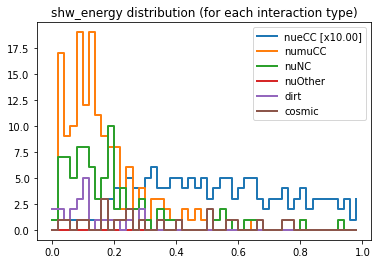

In [311]:
this_bnb = esl_slcpfp_bnb_nu_df[esl_slcpfp_bnb_nu_df.pfp_trackScore < 0.6]
this_nue = esl_slcpfp_nue_nu_df[esl_slcpfp_nue_nu_df.pfp_trackScore < 0.6]

this_bnb = this_bnb[this_bnb.shw_energy == this_bnb.groupby(slc_idx_set).shw_energy.transform(max)]
this_nue = this_nue[this_nue.shw_energy == this_nue.groupby(slc_idx_set).shw_energy.transform(max)]

nue.plot_var(df=this_bnb,
             df_add=this_nue,
             var='shw_energy',
             label='Shower Energy [GeV]',
             bins=np.linspace(0, 1, 51),
             mult_factor=10)